In [1]:
import numpy as np
import time
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from torch.nn.parameter import Parameter

%matplotlib inline
import pylab as pl

from IPython import display
from copy import deepcopy
from skimage.transform import resize
from PIL import Image

In [2]:
# Set Important Values

data = '/data/dww78/mini_inat_nonproto/'
gpu = 2
torch.cuda.set_device(gpu)
workers = 8
vbity = 20
esize = 4
ngiven = 10
threshold = .15

bsize = 15

In [5]:
# Load Training/Testing Data

d_train = torch.load(data+'train_boxes.pth')
d_test = torch.load(data+'val_boxes.pth')
d_boxes = torch.load(data+'box_coords.pth')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4905, 0.4961, 0.4330],std=[0.1737, 0.1713, 0.1779])
    ])

def load_transform(path, pathdict, boxdict, transform, size, msize, flipping, masking):
    flip = np.random.choice([True, False])
    with open(path, 'rb') as f:
        p = Image.open(f)
        p = p.convert('RGB')
    w,h = p.size
    p = p.resize((size, size), Image.BILINEAR)
    if flip and flipping:
        p = p.transpose(Image.FLIP_LEFT_RIGHT)
    t = transform(p)
    if masking:
        mask = np.zeros((h,w))
        boxes = pathdict[path]
        for b in boxes:
            box = boxdict[b]
            xmin = box[0]
            xmax = box[2]+xmin
            ymin = box[1]
            ymax = box[3]+ymin
            if not flip or not flipping:
                mask[ymin:ymax, xmin:xmax] = 1
            else:
                mask[ymin:ymax, w-xmax:w-xmin] = 1
        mask = resize(mask, (msize,msize), mode='constant', cval=0, anti_aliasing=False)
        t = [t, (torch.FloatTensor(mask-threshold).sign()/2+.5).unsqueeze(0)]
    return t

class ProtoSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, data_source):
        iddict = dict()
        for i,(_,cat) in enumerate(data_source.imgs):
            if cat in iddict:
                iddict[cat].append(i)
            else:
                iddict[cat] = [i]
        self.iddict = iddict
        
    def __iter__(self):
        for key in list(self.iddict.keys()):
            idlist = self.iddict[key]
            np.random.shuffle(idlist)
            size = len(idlist)
            if size <= bsize:
                yield idlist
            else:
#                 yield idlist[:bsize] # !
                for i in range(len(idlist)//bsize):
                    yield idlist[i*bsize:(i+1)*bsize]
                if size%bsize != 0:
                    yield idlist[-(len(idlist)%bsize):]

train_dataset = datasets.ImageFolder(
    data+'train', 
    loader = lambda x: load_transform(x, d_train, d_boxes, transform, 84, 21, False, True))
test_dataset = datasets.ImageFolder(
    data+'val',
    loader = lambda x: load_transform(x, d_test, d_boxes, transform, 84, 21, False, False))
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_sampler = ProtoSampler(train_dataset),
    num_workers = workers,
    pin_memory = True)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_sampler = ProtoSampler(test_dataset),
    num_workers = workers,
    pin_memory = True)
print('Data loaded!')
print(len(train_dataset.classes), len(test_dataset.classes))

Data loaded!
227 227


In [4]:
class Block(nn.Module):
    def __init__(self, insize, outsize):
        super(Block, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(insize, outsize, kernel_size=3, padding=1),
            nn.BatchNorm2d(outsize)
        )
        
    def forward(self, inp):
        return self.layers(inp)

# New model (with 4th channel)
class PROTO(nn.Module):
    def __init__(self, inC):
        super(PROTO, self).__init__()
        self.process = nn.Sequential(
            Block(inC,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.AvgPool2d(10)
        )
        
    def forward(self, inp):
        return self.process(inp).view(inp.size(0),-1)
    
class Predictor(nn.Module):
    def __init__(self):
        super(Predictor, self).__init__()
        self.sm = nn.LogSoftmax(dim=-1)
        
    def forward(self, support, query, way):
        distmat = torch.sum((support.unsqueeze(0)-query.unsqueeze(1))**2,2).neg()
        probs = self.sm(distmat)
        return probs
    
class bPROTO(nn.Module):
    def __init__(self):
        super(bPROTO, self).__init__()
        self.process = nn.Sequential(
            Block(3,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            Block(64,64),
            nn.ReLU(inplace=True),
            Block(64,64)
        )
        
    def forward(self, inp):
        return self.process(inp)
    
class cPredictor(nn.Module):
    def __init__(self):
        super(cPredictor, self).__init__()
        
    def forward(self, inp, masks):
        support = inp[:ngiven].unsqueeze(-1) # 10 64 21 21 1
        m = masks[:ngiven] # 10 1 21 21
        c = torch.stack([1-m, m], dim=-1) # 10 1 21 21 2     (Positive class corresponds to index/label 1)
        c = (c*support).contiguous()
        c = c.view(ngiven,inp.size(1),-1,2).mean(2).mean(0) # 64 2
        c = c.unsqueeze(1).unsqueeze(1).unsqueeze(0) # 1 64 1 1 2
        return c
        
class bPredictor(nn.Module):
    def __init__(self):
        super(bPredictor, self).__init__()
        self.sm = nn.Softmax(dim=-1)
        self.upper = nn.Upsample(size=(84,84), mode='bilinear')
        
    def forward(self, inp, cen):
        query = inp.unsqueeze(-1) # B 64 21 21 1
        distmat = ((cen-query)**2).sum(1).neg() # B 21 21 2
        probs = self.sm(distmat)[:,:,:,1]
        return self.upper(probs.unsqueeze(1))

# downer = nn.AvgPool2d(4,stride=4)

m = 0
smodel = PROTO(4).cuda()
# qmodel = PROTO(3).cuda()
bmodel = bPROTO().cuda()
b = torch.load('detectors/saved_models/box_predictors_fixed.pth')
# _,s,q = torch.load('saved_models/retraining_folded_final.torch')
s = torch.load('saved_models/bpred_retrained_fixed_full.torch')
smodel.load_state_dict(s[m])
# qmodel.load_state_dict(q[m])
bmodel.load_state_dict(b[0])
smodel = smodel.eval()
# qmodel = qmodel.eval()
bmodel = bmodel.eval()
predictor = Predictor().cuda()
cpredictor = cPredictor().cuda()
bpredictor = bPredictor().cuda()
# smodel.process[-2].layers[-1].bias.data.zero_()

print("Models built!")

Models built!


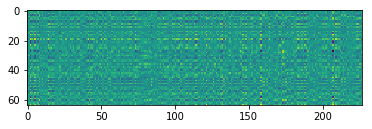

Centroids accumulated!


In [8]:
# Accumulate prototypes

way = 227
centroids = torch.zeros(way, 64).cuda(device = gpu, async=True)
catindex = 0
lastcat = -1
count = 0
running = torch.zeros(64).cuda(device = gpu, async=True)
counts = [0]*way
bcentroids = [None]*way
bcentroid = None
pl.figure(figsize=(20,10))
for i, ((inp, mask), cat) in enumerate(train_loader):
    catindex = cat[0]
        
    # Moving to another category
    if catindex != lastcat: 
        if i != 0:
            bcentroids[lastcat] = bcentroid
            centroids[lastcat] = running/count # Write the values
            counts[lastcat] = count
        lastcat = catindex # Record the current category
        count = 0 # Reset divisor
        running.zero_() # Reset accumulator
        bcentroid = None # Reset box centroids
        display.clear_output(wait=True)
        pl.figure()
        pl.imshow(centroids.transpose(0,1).data.cpu().numpy())
        pl.show()
        time.sleep(.5)
    
        # Predict with masks given
        inp = Variable(inp).cuda(device = gpu, async=True)
        mask = Variable(mask).cuda(device = gpu, async=True)
        with torch.no_grad():
            # Generate centroids
            out = bmodel(inp)
            c = cpredictor(out, mask)
            m = bpredictor(out, c)
#             pl.subplot(1,evalway,cat[0].item()+1)
#             pl.imshow(m[0].squeeze().data.cpu().numpy(), vmin=0, vmax=1)
            bcentroid = c
            # Predict with new masks
            out = smodel(torch.cat([inp,m], dim=1)).sum(0)
            running += out # Accumulate remaining prototypes
        count += inp.size(0)
    
    # Continue accumulating
    else:
        # Predict without masks given
        inp = Variable(inp).cuda(device = gpu, async=True)
        with torch.no_grad():
            m = bpredictor(bmodel(inp), bcentroid)
            out = smodel(torch.cat([inp,m], dim=1)).sum(0)
            running += out # Accumulate prototypes
        count += inp.size(0) # Accumulate the divisor
pl.show()

# Record last category
centroids[catindex] = running/count
bcentroids[catindex] = bcentroid
counts[catindex] = count
display.clear_output(wait=True)
pl.figure()
pl.imshow(centroids.transpose(0,1).data.cpu().numpy())
pl.show()
print('Centroids accumulated!')

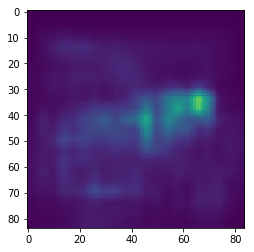

In [12]:
n = 0
pl.imshow(m[n].squeeze().data.cpu().numpy(), vmin=0, vmax=1)

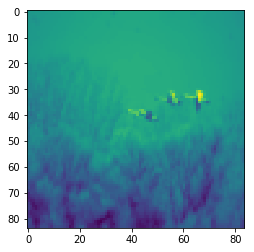

In [13]:
pl.imshow(inp[n,0].data.cpu().numpy())

In [14]:
# Total accuracy, class accuracy
k = 1

right = 0
allright = 0
perclassacc = [0]*way
catindex = 0
lastcat = -1
count = 0
allcount = 0
pl.figure(figsize=(20,10))
for i, (inp, cat) in enumerate(test_loader):
    catindex = cat[0]
    if catindex != lastcat: # We're about to move to another category
        if catindex%10==0:
            print(catindex.item())
        # Write the values
        if i!= 0:
            allright += right.item() 
            allcount += count
            perclassacc[lastcat] = right.item()/count
        lastcat = catindex # Record the current category
        count = 0 # Reset divisor
        right = 0 # Reset accumulator
    
    # Predict
    inp = Variable(inp).cuda(device = gpu, async=True)
    targ = Variable(cat).cuda(device = gpu, async=True)
    with torch.no_grad():
        m = bpredictor(bmodel(inp), bcentroids[catindex])
#         pl.subplot(1,evalway,i+1)
#         pl.imshow(m[0].squeeze().data.cpu().numpy())
        inp = torch.cat([inp,m], dim=1).contiguous()
        out = predictor(centroids, smodel(inp), way)
        _, pred = out.topk(k, 1, True, True)
        pred = pred.t()
        right += pred.eq(targ.view(1, -1).expand_as(pred))[:k].view(-1).float().sum(0, keepdim=True)
    count += inp.size(0)
pl.show()
    
#     print(targ)
#     print(bins)
#     print(right)
#     assert False

# Record last category
allright += right.item()
allcount += count
perclassacc[catindex] = right.item()/count

# Final reporting / recording
allacc = allright/allcount
print('Total Accuracy: %f\nPer Class Accuracy: %f'%(allacc, np.mean(perclassacc)))

# torch.save((allacc, np.mean(perclassacc)), 'maxway_accs.pth')

0


/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/home/dww78/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:1961: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220


<Figure size 1440x720 with 0 Axes>

Total Accuracy: 0.671166
Per Class Accuracy: 0.683122


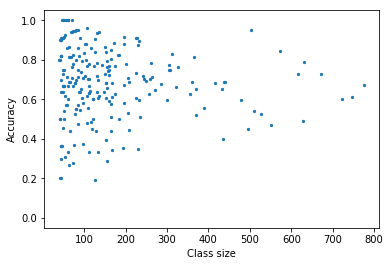

In [15]:
pl.figure()
pl.scatter(counts, perclassacc, s=5)
pl.ylim([-.05,1.05])
pl.xlabel('Class size')
pl.ylabel('Accuracy')
pl.show()

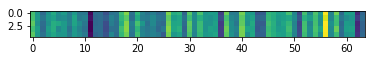

In [221]:
pl.imshow(centroids.data.cpu().numpy())

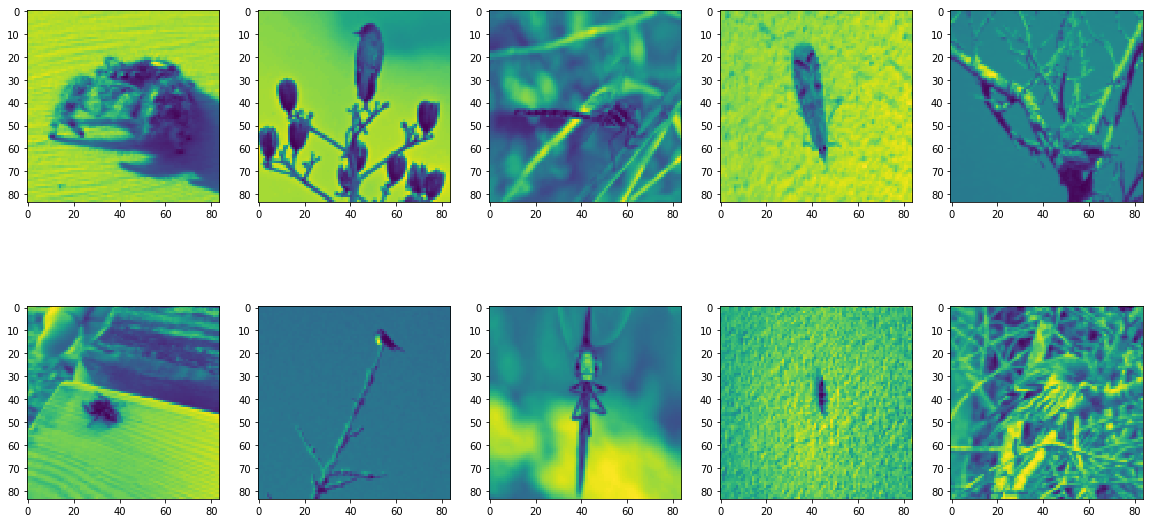

In [220]:
evalway = way
pl.figure(figsize=(20,10))
for i, (inp, cat) in enumerate(test_loader):
    pl.subplot(2,evalway,i+1)
    pl.imshow(inp[0,0].data.cpu().numpy())
    pl.subplot(2,evalway,evalway+i+1)
    pl.imshow(inp[ngiven,0].data.cpu().numpy())
pl.show()